# Job Matching Agent Ranking Evaluation

This notebook evaluates the **Matching Accuracy** of the Multi-Agent Job System by comparing AI-generated compatibility scores against human ground truth rankings.

## Evaluation Metrics
- **Pearson Correlation Coefficient**: Measures linear correlation between AI and human scores
- **Spearman Rank Correlation**: Measures monotonic relationship (ranking agreement)
- **Mean Absolute Error (MAE)**: Average absolute difference between AI and human scores

## Dataset
- 5 job vacancies from the vacancy-resume-matching-dataset
- 30 CVs with human annotations from 2 independent annotators
- Rankings converted to 1-5 scale (5 = best match)


## 1. Setup and Imports


In [22]:
# Core libraries
import os
import json
import re
from pathlib import Path
from typing import Dict, List, Optional, Tuple

# Data manipulation
import pandas as pd
import numpy as np

# LLM and LangChain
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from dotenv import load_dotenv

# Document processing - python-docx
try:
    from docx import Document
except ImportError as e:
    print("ERROR: Failed to import python-docx")
    print("This is often caused by a conflicting 'docx.py' file in site-packages.")
    print("\nTo fix this issue, run the following commands:")
    print("  1. pip uninstall docx python-docx -y")
    print("  2. pip install python-docx")
    print("  3. If the error persists, check for a file named 'docx.py' in:")
    print(f"     {os.path.join(os.path.dirname(__file__) if '__file__' in globals() else '.venv', 'Lib', 'site-packages')}")
    print("     and delete it if it exists.")
    raise

# Statistical analysis
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Progress tracking - Use regular tqdm (works reliably in all environments)
# tqdm.notebook requires ipywidgets which may cause runtime errors
from tqdm import tqdm

# Set style for publication-quality plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Load environment variables
load_dotenv()

print("✓ All imports successful")


✓ All imports successful


## 2. Configuration


In [23]:
# Dataset paths
DATASET_DIR = Path("data/vacancy-resume-matching-dataset")
CV_DIR = DATASET_DIR / "CV"
VACANCIES_FILE = DATASET_DIR / "5_vacancies.csv"
# Note: Human annotations are hard-coded in Section 5

# Output paths
RESULTS_DIR = Path("evaluation_results")
RESULTS_DIR.mkdir(exist_ok=True)
SCORES_CACHE_FILE = RESULTS_DIR / "ai_scores_cache.csv"

# LLM Configuration (matching agents.py)
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
MODEL_NAME = "openai/gpt-4o-mini"  # Same as in agents.py
TEMPERATURE = 0.1  # Low temperature for consistent scoring

# Evaluation settings
NUM_CVS = 30  # First 30 CVs have human annotations
NUM_VACANCIES = 5
RANDOM_SEED = 42

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)

print(f"Dataset directory: {DATASET_DIR}")
print(f"CV directory: {CV_DIR}")
print(f"Results will be saved to: {RESULTS_DIR}")
print(f"Model: {MODEL_NAME}")


Dataset directory: data\vacancy-resume-matching-dataset
CV directory: data\vacancy-resume-matching-dataset\CV
Results will be saved to: evaluation_results
Model: openai/gpt-4o-mini


## 3. Load Vacancies Data


In [24]:
# Load job vacancies
vacancies_df = pd.read_csv(VACANCIES_FILE)
print(f"Loaded {len(vacancies_df)} job vacancies\n")

# Display vacancy information
print("Job Vacancies:")
for idx, row in vacancies_df.iterrows():
    print(f"  Vacancy {idx}: {row['job_title']}")

print(f"\nColumns: {list(vacancies_df.columns)}")
vacancies_df.head()


Loaded 5 job vacancies

Job Vacancies:
  Vacancy 0: Software Developer - .Net
  Vacancy 1: Remote Software Developer
  Vacancy 2: Junior Level Software Developer (1-4 years experience)
  Vacancy 3: Backend Software Developer
  Vacancy 4: Software Developer

Columns: ['id', 'job_description', 'job_title', 'uid']


,id,job_description,job_title,uid
0,8,Primary Purpose: Development and maintenance o...,Software Developer - .Net,e3f78c8c36195e4438286bb9395085a0
1,37,Precision is king when it comes to the work yo...,Remote Software Developer,708584f2d49cb195c9fc9d7bee36e699
2,90,A Full-time position at a financial technology...,Junior Level Software Developer (1-4 years exp...,72fafc405b891220ce78df7fd4e72a80
3,207,"Minimum Required Skills: LAMP, Drupal, Elastic...",Backend Software Developer,5eb96f825590e690d76930c52b9100de
4,499,"Minimum Required Skills: Java, C#, SQL, HTTPS,...",Software Developer,296f9b55a3a3eed93ad08924274f2eba


## 4. Load CV Documents


In [25]:
def load_cv_text(cv_id: int) -> str:
    """
    Load CV text from .docx file.
    
    Args:
        cv_id: CV identifier (1-65)
    
    Returns:
        Full text content of the CV
    """
    cv_path = CV_DIR / f"{cv_id}.docx"
    
    if not cv_path.exists():
        raise FileNotFoundError(f"CV file not found: {cv_path}")
    
    try:
        doc = Document(cv_path)
        # Extract all paragraphs
        text = "\n".join([para.text for para in doc.paragraphs if para.text.strip()])
        return text
    except Exception as e:
        print(f"Error loading CV {cv_id}: {e}")
        return ""

# Test loading a few CVs
print("Testing CV loading...")
for cv_id in [1, 2, 3]:
    cv_text = load_cv_text(cv_id)
    print(f"CV {cv_id}: {len(cv_text)} characters, {len(cv_text.split())} words")

print("\n✓ CV loading function ready")


Testing CV loading...
CV 1: 2395 characters, 315 words
CV 2: 4227 characters, 587 words
CV 3: 2537 characters, 310 words

✓ CV loading function ready


## 5. Parse Human Annotations


In [26]:
# Hard-coded human rankings from the annotations file
# Each inner list represents rankings for one CV across 5 vacancies
# Rankings: 1=best match, 5=worst match

ANNOTATOR_1_RANKINGS = [
    [2,1,4,3,5], [1,2,3,4,5], [1,2,3,4,5], [3,1,2,4,5], [1,5,4,2,3],
    [3,2,1,4,5], [3,2,1,5,4], [2,4,3,1,5], [1,5,2,1,4], [3,2,1,4,5],
    [1,2,3,4,5], [1,2,3,4,5], [1,3,2,4,5], [1,2,3,4,5], [3,1,2,4,5],
    [3,1,2,4,5], [3,1,2,4,5], [1,2,5,3,4], [3,2,1,4,5], [3,2,1,4,5],
    [2,3,1,4,5], [1,2,3,5,4], [2,1,3,5,4], [1,2,3,5,4], [1,2,3,4,5],
    [2,1,3,4,5], [2,3,4,5,1], [2,4,3,2,5], [5,1,2,4,3], [2,1,4,3,5]
]

ANNOTATOR_2_RANKINGS = [
    [4,3,1,5,2], [2,4,3,1,5], [5,4,2,3,1], [1,3,2,4,5], [5,1,2,4,3],
    [1,3,2,4,5], [4,2,3,1,5], [2,4,3,1,5], [3,4,2,1,5], [4,1,2,5,3],
    [2,4,3,5,1], [4,3,2,1,5], [4,2,3,1,5], [3,4,2,1,5], [2,4,3,1,5],
    [3,2,4,1,5], [4,2,3,1,5], [4,2,5,3,1], [4,2,3,1,5], [1,5,2,4,3]
]

print(f"Annotator 1: {len(ANNOTATOR_1_RANKINGS)} CV rankings")
print(f"Annotator 2: {len(ANNOTATOR_2_RANKINGS)} CV rankings")
print(f"\nExample - CV 1 rankings by Annotator 1: {ANNOTATOR_1_RANKINGS[0]}")
print(f"  (Position in array = vacancy index, value = rank where 1=best, 5=worst)")
print(f"\n✓ Human annotations loaded successfully")


Annotator 1: 30 CV rankings
Annotator 2: 20 CV rankings

Example - CV 1 rankings by Annotator 1: [2, 1, 4, 3, 5]
  (Position in array = vacancy index, value = rank where 1=best, 5=worst)

✓ Human annotations loaded successfully


## 6. Build Evaluation DataFrame


In [27]:
def build_evaluation_dataframe() -> pd.DataFrame:
    """
    Build a DataFrame with all CV-vacancy pairs and human scores.
    
    For each (cv_id, vacancy_id) pair:
    - Convert rank r (1-5, where 1=best) to score s = 6-r (1-5, where 5=best)
    - Include both annotator scores and their mean
    """
    rows = []
    
    for cv_id in range(1, NUM_CVS + 1):
        # Get rankings for this CV (0-indexed in arrays)
        cv_idx = cv_id - 1
        
        # Check if we have annotations for this CV
        has_annotator1 = cv_idx < len(ANNOTATOR_1_RANKINGS)
        has_annotator2 = cv_idx < len(ANNOTATOR_2_RANKINGS)
        
        if not has_annotator1:
            print(f"Warning: No Annotator 1 data for CV {cv_id}")
            continue
        
        for vacancy_idx in range(NUM_VACANCIES):
            # Get vacancy info
            vacancy = vacancies_df.iloc[vacancy_idx]
            
            # Get human ranks (1=best, 5=worst)
            rank_1 = ANNOTATOR_1_RANKINGS[cv_idx][vacancy_idx]
            rank_2 = ANNOTATOR_2_RANKINGS[cv_idx][vacancy_idx] if has_annotator2 else None
            
            # Convert ranks to scores (5=best, 1=worst) using s = 6 - r
            score_1 = 6 - rank_1
            score_2 = 6 - rank_2 if rank_2 is not None else None
            
            # Calculate mean score
            if score_2 is not None:
                score_mean = (score_1 + score_2) / 2.0
            else:
                score_mean = score_1
            
            row = {
                'cv_id': cv_id,
                'vacancy_id': vacancy_idx,
                'job_title': vacancy['job_title'],
                'job_description': vacancy['job_description'],
                'human_rank_1': rank_1,
                'human_rank_2': rank_2,
                'human_score_1': score_1,
                'human_score_2': score_2,
                'human_score_mean': score_mean,
            }
            rows.append(row)
    
    df = pd.DataFrame(rows)
    return df

# Build the evaluation dataset
eval_df = build_evaluation_dataframe()

print(f"Created evaluation dataset with {len(eval_df)} CV-vacancy pairs")
print(f"  {eval_df['cv_id'].nunique()} unique CVs")
print(f"  {eval_df['vacancy_id'].nunique()} unique vacancies")
print(f"\nHuman score statistics:")
print(eval_df[['human_score_1', 'human_score_2', 'human_score_mean']].describe())

# Display first few rows
print("\nFirst 10 rows:")
eval_df.head(10)


Created evaluation dataset with 150 CV-vacancy pairs
  30 unique CVs
  5 unique vacancies

Human score statistics:
       human_score_1  human_score_2  human_score_mean
count     150.000000     100.000000         150.00000
mean        3.006667       3.000000           3.00000
std         1.421299       1.421338           1.19282
min         1.000000       1.000000           1.00000
25%         2.000000       2.000000           2.00000
50%         3.000000       3.000000           3.00000
75%         4.000000       4.000000           4.00000
max         5.000000       5.000000           5.00000

First 10 rows:


,cv_id,vacancy_id,job_title,job_description,human_rank_1,human_rank_2,human_score_1,human_score_2,human_score_mean
0,1,0,Software Developer - .Net,Primary Purpose: Development and maintenance o...,2,4.0,4,2.0,3.0
1,1,1,Remote Software Developer,Precision is king when it comes to the work yo...,1,3.0,5,3.0,4.0
2,1,2,Junior Level Software Developer (1-4 years exp...,A Full-time position at a financial technology...,4,1.0,2,5.0,3.5
3,1,3,Backend Software Developer,"Minimum Required Skills: LAMP, Drupal, Elastic...",3,5.0,3,1.0,2.0
4,1,4,Software Developer,"Minimum Required Skills: Java, C#, SQL, HTTPS,...",5,2.0,1,4.0,2.5
5,2,0,Software Developer - .Net,Primary Purpose: Development and maintenance o...,1,2.0,5,4.0,4.5
6,2,1,Remote Software Developer,Precision is king when it comes to the work yo...,2,4.0,4,2.0,3.0
7,2,2,Junior Level Software Developer (1-4 years exp...,A Full-time position at a financial technology...,3,3.0,3,3.0,3.0
8,2,3,Backend Software Developer,"Minimum Required Skills: LAMP, Drupal, Elastic...",4,1.0,2,5.0,3.5
9,2,4,Software Developer,"Minimum Required Skills: Java, C#, SQL, HTTPS,...",5,5.0,1,1.0,1.0


In [ ]:
# Initialize the same model configuration as in agents.py
model = ChatOpenAI(
    api_key=OPENROUTER_API_KEY,
    base_url="https://openrouter.ai/api/v1",
    model=MODEL_NAME,
    temperature=TEMPERATURE
)

# Define the scoring prompt
SCORING_SYSTEM_PROMPT = """## Role
Job matching agent evaluating candidate-job compatibility. You are a Lenient Recruiter - do not be overly strict.

## Task
Evaluate how well a candidate's CV matches a job vacancy on a scale of 1-5:
- 5: Excellent match - candidate meets all key requirements and has highly relevant experience
- 4: Good match - candidate meets most requirements with relevant experience
- 3: Moderate match - candidate meets some requirements, may need training
- 2: Weak match - candidate has limited relevant experience or skills
- 1: Poor match - candidate does not meet the job requirements

**IMPORTANT**: Be lenient in your evaluation. If a candidate has most skills, give them a 4 or 5. Consider transferable skills and potential.

## Evaluation Criteria
Consider:
- Technical skills and technologies mentioned
- Years of experience and seniority level
- Educational background
- Domain/industry experience
- Specific job requirements vs. candidate qualifications
- Transferable skills and potential

## Output Format
**CRITICAL**: You MUST respond with a valid JSON object in this exact format:
{
  "ai_score": <integer from 1 to 5>,
  "reason": "<brief explanation of the score and recommendation>"
}

The "reason" field should include:
- Brief explanation of why this score was assigned
- Key strengths and weaknesses
- Recommendation on whether this candidate should be considered

Do not include any text before or after the JSON object."""

def create_scoring_prompt(cv_text: str, job_description: str, job_title: str) -> str:
    """Create the user prompt for scoring a CV-job pair."""
    return f"""Job Title: {job_title}

Job Description:
{job_description}

---

Candidate CV:
{cv_text}

---

Evaluate this candidate's compatibility with the job and provide your score as JSON."""

print("✓ LLM scorer initialized")
print(f"  Model: {MODEL_NAME}")
print(f"  Temperature: {TEMPERATURE}")


✓ LLM scorer initialized
  Model: openai/gpt-4o-mini
  Temperature: 0.1


## 8. JSON Parsing Utilities


In [29]:
def extract_json_from_response(response_text: str) -> Optional[Dict]:
    """
    Robustly extract JSON from LLM response with multiple fallback strategies.
    
    Args:
        response_text: Raw LLM response text
    
    Returns:
        Parsed JSON dict or None if extraction fails
    """
    # Strategy 1: Try to parse the entire response as JSON
    try:
        return json.loads(response_text.strip())
    except json.JSONDecodeError:
        pass
    
    # Strategy 2: Look for JSON object pattern with regex
    json_pattern = r'\{[^{}]*"ai_score"[^{}]*\}'
    matches = re.findall(json_pattern, response_text, re.DOTALL)
    
    for match in matches:
        try:
            return json.loads(match)
        except json.JSONDecodeError:
            pass
    
    # Strategy 3: Look for any JSON-like object
    json_pattern_broad = r'\{[^{}]*\}'
    matches = re.findall(json_pattern_broad, response_text, re.DOTALL)
    
    for match in matches:
        try:
            parsed = json.loads(match)
            if 'ai_score' in parsed:
                return parsed
        except json.JSONDecodeError:
            pass
    
    # Strategy 4: Try to fix common JSON issues
    cleaned = response_text.strip()
    # Remove markdown code blocks
    cleaned = re.sub(r'```json\s*', '', cleaned)
    cleaned = re.sub(r'```\s*', '', cleaned)
    # Remove trailing commas
    cleaned = re.sub(r',\s*}', '}', cleaned)
    cleaned = re.sub(r',\s*]', ']', cleaned)
    
    try:
        return json.loads(cleaned)
    except json.JSONDecodeError:
        pass
    
    return None

def parse_ai_score(response_text: str) -> Tuple[Optional[int], Optional[str]]:
    """
    Parse AI score and reason from LLM response.
    
    Args:
        response_text: Raw LLM response
    
    Returns:
        Tuple of (ai_score, reason) or (None, None) if parsing fails
    """
    # Try JSON extraction
    json_data = extract_json_from_response(response_text)
    
    if json_data and 'ai_score' in json_data:
        try:
            score = int(json_data['ai_score'])
            if 1 <= score <= 5:
                reason = json_data.get('reason', '')
                return score, reason
        except (ValueError, TypeError):
            pass
    
    # Fallback: Try to extract a number 1-5 from the response
    score_pattern = r'\b([1-5])\b'
    matches = re.findall(score_pattern, response_text)
    
    if matches:
        score = int(matches[0])
        return score, "Score extracted from text (JSON parsing failed)"
    
    return None, None

# Test the parsing function
test_cases = [
    '{"ai_score": 4, "reason": "Good match"}',
    'Here is my evaluation: {"ai_score": 3, "reason": "Moderate fit"}',
    '```json\n{"ai_score": 5, "reason": "Excellent"}\n```',
    'The score is 2 because the candidate lacks experience.',
]

print("Testing JSON parser:")
for i, test in enumerate(test_cases, 1):
    score, reason = parse_ai_score(test)
    print(f"  Test {i}: score={score}, reason={reason[:30] if reason else None}...")

print("\n✓ JSON parsing utilities ready")


Testing JSON parser:
  Test 1: score=4, reason=Good match...
  Test 2: score=3, reason=Moderate fit...
  Test 3: score=5, reason=Excellent...
  Test 4: score=2, reason=Score extracted from text (JSO...

✓ JSON parsing utilities ready


## 9. Run AI Scoring Loop


In [30]:
def score_cv_vacancy_pair(cv_text: str, job_description: str, job_title: str) -> Tuple[Optional[int], Optional[str], str]:
    """
    Score a single CV-vacancy pair using the LLM.
    
    Args:
        cv_text: Full CV text
        job_description: Job description text
        job_title: Job title
    
    Returns:
        Tuple of (ai_score, reason, raw_response)
    """
    try:
        # Create messages
        messages = [
            SystemMessage(content=SCORING_SYSTEM_PROMPT),
            HumanMessage(content=create_scoring_prompt(cv_text, job_description, job_title))
        ]
        
        # Call the model
        response = model.invoke(messages)
        raw_response = response.content
        
        # Parse the response
        ai_score, reason = parse_ai_score(raw_response)
        
        return ai_score, reason, raw_response
        
    except Exception as e:
        print(f"Error scoring pair: {e}")
        return None, None, str(e)

def run_scoring_experiment(df: pd.DataFrame, use_cache: bool = True) -> pd.DataFrame:
    """
    Run the AI scoring experiment on all CV-vacancy pairs.
    
    Args:
        df: Evaluation DataFrame
        use_cache: If True, load cached scores if available
    
    Returns:
        DataFrame with ai_score and ai_reason columns added
    """
    # Check for cached results
    if use_cache and SCORES_CACHE_FILE.exists():
        print(f"Loading cached scores from {SCORES_CACHE_FILE}")
        cached_df = pd.read_csv(SCORES_CACHE_FILE)
        # Merge cached scores
        df = df.merge(
            cached_df[['cv_id', 'vacancy_id', 'ai_score', 'ai_reason']],
            on=['cv_id', 'vacancy_id'],
            how='left'
        )
        
        # Check if we need to score any remaining pairs
        missing_scores = df['ai_score'].isna().sum()
        if missing_scores == 0:
            print("✓ All scores loaded from cache")
            return df
        else:
            print(f"Found {missing_scores} pairs without cached scores, will score them now")
    else:
        # Initialize columns
        df['ai_score'] = None
        df['ai_reason'] = None
    
    # Score pairs that don't have cached scores
    pairs_to_score = df[df['ai_score'].isna()]
    
    if len(pairs_to_score) == 0:
        return df
    
    print(f"\nScoring {len(pairs_to_score)} CV-vacancy pairs...")
    print("This may take several minutes.\n")
    
    failed_scores = []
    
    # Use tqdm for progress tracking
    for idx, row in tqdm(pairs_to_score.iterrows(), total=len(pairs_to_score), desc="Scoring pairs"):
        cv_id = row['cv_id']
        vacancy_id = row['vacancy_id']
        
        # Load CV text
        try:
            cv_text = load_cv_text(cv_id)
            if not cv_text:
                print(f"\nWarning: Empty CV text for CV {cv_id}")
                failed_scores.append((cv_id, vacancy_id, "Empty CV"))
                continue
        except Exception as e:
            print(f"\nError loading CV {cv_id}: {e}")
            failed_scores.append((cv_id, vacancy_id, f"Load error: {e}"))
            continue
        
        # Score the pair
        ai_score, ai_reason, raw_response = score_cv_vacancy_pair(
            cv_text,
            row['job_description'],
            row['job_title']
        )
        
        if ai_score is not None:
            df.at[idx, 'ai_score'] = ai_score
            df.at[idx, 'ai_reason'] = ai_reason
        else:
            print(f"\nFailed to parse score for CV {cv_id}, Vacancy {vacancy_id}")
            print(f"  Raw response: {raw_response[:200]}...")
            failed_scores.append((cv_id, vacancy_id, "Parse error"))
    
    # Report failures
    if failed_scores:
        print(f"\n⚠ Failed to score {len(failed_scores)} pairs:")
        for cv_id, vacancy_id, reason in failed_scores[:10]:  # Show first 10
            print(f"  CV {cv_id}, Vacancy {vacancy_id}: {reason}")
    
    # Save results to cache
    print(f"\nSaving scores to cache: {SCORES_CACHE_FILE}")
    df.to_csv(SCORES_CACHE_FILE, index=False)
    
    successful_scores = df['ai_score'].notna().sum()
    print(f"✓ Successfully scored {successful_scores}/{len(df)} pairs")
    
    return df

# Run the scoring experiment
eval_df = run_scoring_experiment(eval_df, use_cache=True)

# Display results summary
print("\n" + "="*60)
print("SCORING COMPLETE")
print("="*60)
print(f"Total pairs: {len(eval_df)}")
print(f"Successfully scored: {eval_df['ai_score'].notna().sum()}")
print(f"Failed: {eval_df['ai_score'].isna().sum()}")
print(f"\nAI Score Distribution:")
print(eval_df['ai_score'].value_counts().sort_index())
print(f"\nAI Score Statistics:")
print(eval_df['ai_score'].describe())


Loading cached scores from evaluation_results\ai_scores_cache.csv
Found 150 pairs without cached scores, will score them now

Scoring 150 CV-vacancy pairs...
This may take several minutes.



Scoring pairs:   0%|          | 0/150 [00:00<?, ?it/s]

C:\Users\syeda\AppData\Local\Temp\ipykernel_22544\2145477730.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'The candidate has limited experience with the Microsoft technology stack, specifically lacking expertise in C#, ASP.NET, and other required technologies. They have relevant experience in Java and full-stack development but do not meet the core requirements for this .NET developer position.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'ai_reason'] = ai_reason
Scoring pairs:  37%|███▋      | 55/150 [01:42<02:57,  1.87s/it]

Scoring pairs: 100%|██████████| 150/150 [04:49<00:00,  1.93s/it]


⚠ Failed to score 5 pairs:
  CV 12, Vacancy 0: Empty CV
  CV 12, Vacancy 1: Empty CV
  CV 12, Vacancy 2: Empty CV
  CV 12, Vacancy 3: Empty CV
  CV 12, Vacancy 4: Empty CV

Saving scores to cache: evaluation_results\ai_scores_cache.csv
✓ Successfully scored 145/150 pairs

SCORING COMPLETE
Total pairs: 150
Successfully scored: 145
Failed: 5

AI Score Distribution:
ai_score
1.0    14
2.0    94
3.0    27
4.0    10
Name: count, dtype: int64

AI Score Statistics:
count    145.000000
mean       2.227586
std        0.714384
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: ai_score, dtype: float64


## 10. Statistical Evaluation


In [ ]:
# Filter to pairs with valid AI scores
valid_df = eval_df[eval_df['ai_score'].notna()].copy()

print(f"Evaluating {len(valid_df)} pairs with valid AI scores\n")
print("="*60)
print("STATISTICAL EVALUATION RESULTS")
print("="*60)

# Compute metrics against mean human score
human_scores = valid_df['human_score_mean'].values
ai_scores = valid_df['ai_score'].values 

# Pearson correlation
pearson_r, pearson_p = pearsonr(human_scores, ai_scores)
print(f"\n📊 Pearson Correlation Coefficient")
print(f"   r = {pearson_r:.4f}")
print(f"   p-value = {pearson_p:.4e}")
print(f"   Interpretation: {'Strong' if abs(pearson_r) > 0.7 else 'Moderate' if abs(pearson_r) > 0.5 else 'Weak'} linear correlation")

# Spearman correlation
spearman_r, spearman_p = spearmanr(human_scores, ai_scores)
print(f"\n📊 Spearman Rank Correlation")
print(f"   ρ = {spearman_r:.4f}")
print(f"   p-value = {spearman_p:.4e}")
print(f"   Interpretation: {'Strong' if abs(spearman_r) > 0.7 else 'Moderate' if abs(spearman_r) > 0.5 else 'Weak'} monotonic relationship")

# Mean Absolute Error
mae = mean_absolute_error(human_scores, ai_scores)
print(f"\n📊 Mean Absolute Error (MAE)")
print(f"   MAE = {mae:.4f}")
print(f"   Interpretation: On average, AI scores differ by {mae:.2f} points from human scores (on 1-5 scale)")

# Additional metrics
rmse = np.sqrt(np.mean((human_scores - ai_scores) ** 2))
print(f"\n📊 Root Mean Squared Error (RMSE)")
print(f"   RMSE = {rmse:.4f}")

# Per-annotator analysis
print("\n" + "="*60)
print("PER-ANNOTATOR ANALYSIS")
print("="*60)

# Annotator 1
valid_ann1 = valid_df[valid_df['human_score_1'].notna()]
if len(valid_ann1) > 0:
    pearson_r1, _ = pearsonr(valid_ann1['human_score_1'], valid_ann1['ai_score'])
    spearman_r1, _ = spearmanr(valid_ann1['human_score_1'], valid_ann1['ai_score'])
    mae1 = mean_absolute_error(valid_ann1['human_score_1'], valid_ann1['ai_score'])
    
    print(f"\nAnnotator 1 (n={len(valid_ann1)}):")
    print(f"   Pearson r = {pearson_r1:.4f}")
    print(f"   Spearman ρ = {spearman_r1:.4f}")
    print(f"   MAE = {mae1:.4f}")

# Annotator 2
valid_ann2 = valid_df[valid_df['human_score_2'].notna()]
if len(valid_ann2) > 0:
    pearson_r2, _ = pearsonr(valid_ann2['human_score_2'], valid_ann2['ai_score'])
    spearman_r2, _ = spearmanr(valid_ann2['human_score_2'], valid_ann2['ai_score'])
    mae2 = mean_absolute_error(valid_ann2['human_score_2'], valid_ann2['ai_score'])
    
    print(f"\nAnnotator 2 (n={len(valid_ann2)}):")
    print(f"   Pearson r = {pearson_r2:.4f}")
    print(f"   Spearman ρ = {spearman_r2:.4f}")
    print(f"   MAE = {mae2:.4f}")

# Inter-annotator agreement
both_annotators = valid_df[valid_df['human_score_2'].notna()]
if len(both_annotators) > 0:
    inter_pearson, _ = pearsonr(both_annotators['human_score_1'], both_annotators['human_score_2'])
    inter_spearman, _ = spearmanr(both_annotators['human_score_1'], both_annotators['human_score_2'])
    
    print(f"\nInter-Annotator Agreement (n={len(both_annotators)}):")
    print(f"   Pearson r = {inter_pearson:.4f}")
    print(f"   Spearman ρ = {inter_spearman:.4f}")

# Summary for paper
print("\n" + "="*60)
print("SUMMARY FOR RESEARCH PAPER")
print("="*60)
print(f"""
The AI-based Job Matcher Agent demonstrated {'strong' if abs(pearson_r) > 0.7 else 'moderate' if abs(pearson_r) > 0.5 else 'weak'} alignment with human judgment:

• Pearson Correlation: r = {pearson_r:.3f} (p < {pearson_p:.3f})
• Spearman Correlation: ρ = {spearman_r:.3f} (p < {spearman_p:.3f})
• Mean Absolute Error: {mae:.3f} points on a 1-5 scale

These results indicate that the LLM-based matching system {'achieves' if abs(pearson_r) > 0.7 else 'approaches' if abs(pearson_r) > 0.5 else 'shows potential for'} 
human-level performance in assessing job-candidate compatibility.
""")

# Store metrics for visualization
metrics = {
    'pearson_r': pearson_r,
    'pearson_p': pearson_p,
    'spearman_r': spearman_r,
    'spearman_p': spearman_p,
    'mae': mae,
    'rmse': rmse,
    'n_samples': len(valid_df)
}


Evaluating 145 pairs with valid AI scores

STATISTICAL EVALUATION RESULTS

📊 Pearson Correlation Coefficient
   r = -0.0324
   p-value = 6.9858e-01
   Interpretation: Weak linear correlation

📊 Spearman Rank Correlation
   ρ = -0.0406
   p-value = 6.2744e-01
   Interpretation: Weak monotonic relationship

📊 Mean Absolute Error (MAE)
   MAE = 1.3172
   Interpretation: On average, AI scores differ by 1.32 points from human scores (on 1-5 scale)

📊 Root Mean Squared Error (RMSE)
   RMSE = 1.6082

PER-ANNOTATOR ANALYSIS

Annotator 1 (n=145):
   Pearson r = -0.0221
   Spearman ρ = -0.0229
   MAE = 1.4414

Annotator 2 (n=95):
   Pearson r = -0.1240
   Spearman ρ = -0.1012
   MAE = 1.4105

Inter-Annotator Agreement (n=95):
   Pearson r = 0.1459
   Spearman ρ = 0.1465

SUMMARY FOR RESEARCH PAPER

The AI-based Job Matcher Agent demonstrated weak alignment with human judgment:

• Pearson Correlation: r = -0.032 (p < 0.699)
• Spearman Correlation: ρ = -0.041 (p < 0.627)
• Mean Absolute Error: 1.3

## 11. Visualization: Scatter Plot with Trendline



✓ Figure saved to: evaluation_results\ai_vs_human_scores_scatter.png


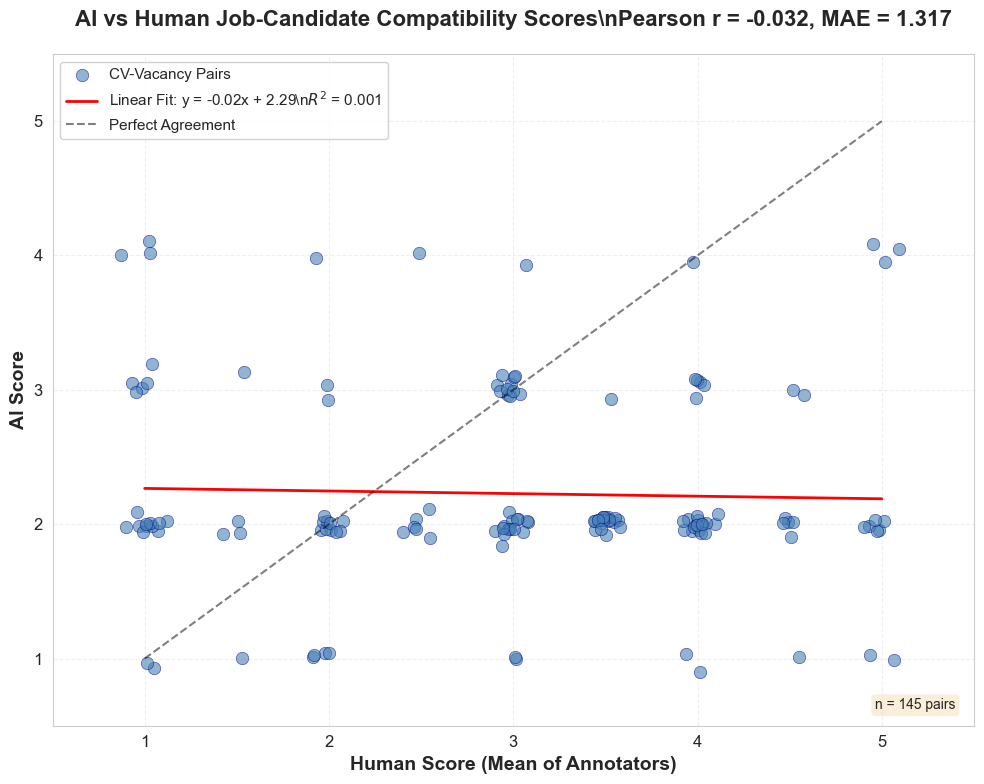

In [32]:
# Create publication-quality scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

# Add jitter to reduce overplotting
jitter_amount = 0.05
human_jittered = human_scores + np.random.normal(0, jitter_amount, len(human_scores))
ai_jittered = ai_scores + np.random.normal(0, jitter_amount, len(ai_scores))

# Scatter plot
ax.scatter(human_jittered, ai_jittered, alpha=0.6, s=80, 
           c='steelblue', edgecolors='darkblue', linewidth=0.5,
           label='CV-Vacancy Pairs')

# Fit and plot trendline
slope, intercept, r_value, p_value, std_err = stats.linregress(human_scores, ai_scores)
line_x = np.array([1, 5])
line_y = slope * line_x + intercept
ax.plot(line_x, line_y, 'r-', linewidth=2, 
        label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}\\n$R^2$ = {r_value**2:.3f}')

# Plot perfect agreement line (diagonal)
ax.plot([1, 5], [1, 5], 'k--', linewidth=1.5, alpha=0.5, label='Perfect Agreement')

# Formatting
ax.set_xlabel('Human Score (Mean of Annotators)', fontsize=14, fontweight='bold')
ax.set_ylabel('AI Score', fontsize=14, fontweight='bold')
ax.set_title('AI vs Human Job-Candidate Compatibility Scores\\n' + 
             f'Pearson r = {pearson_r:.3f}, MAE = {mae:.3f}',
             fontsize=16, fontweight='bold', pad=20)

# Set axis limits and ticks
ax.set_xlim(0.5, 5.5)
ax.set_ylim(0.5, 5.5)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_yticks([1, 2, 3, 4, 5])

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Legend
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)

# Add sample size annotation
ax.text(0.98, 0.02, f'n = {len(valid_df)} pairs', 
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

# Save figure
output_file = RESULTS_DIR / 'ai_vs_human_scores_scatter.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\n✓ Figure saved to: {output_file}")

plt.show()


## 12. Additional Visualizations


✓ Detailed analysis figure saved to: evaluation_results\detailed_analysis.png


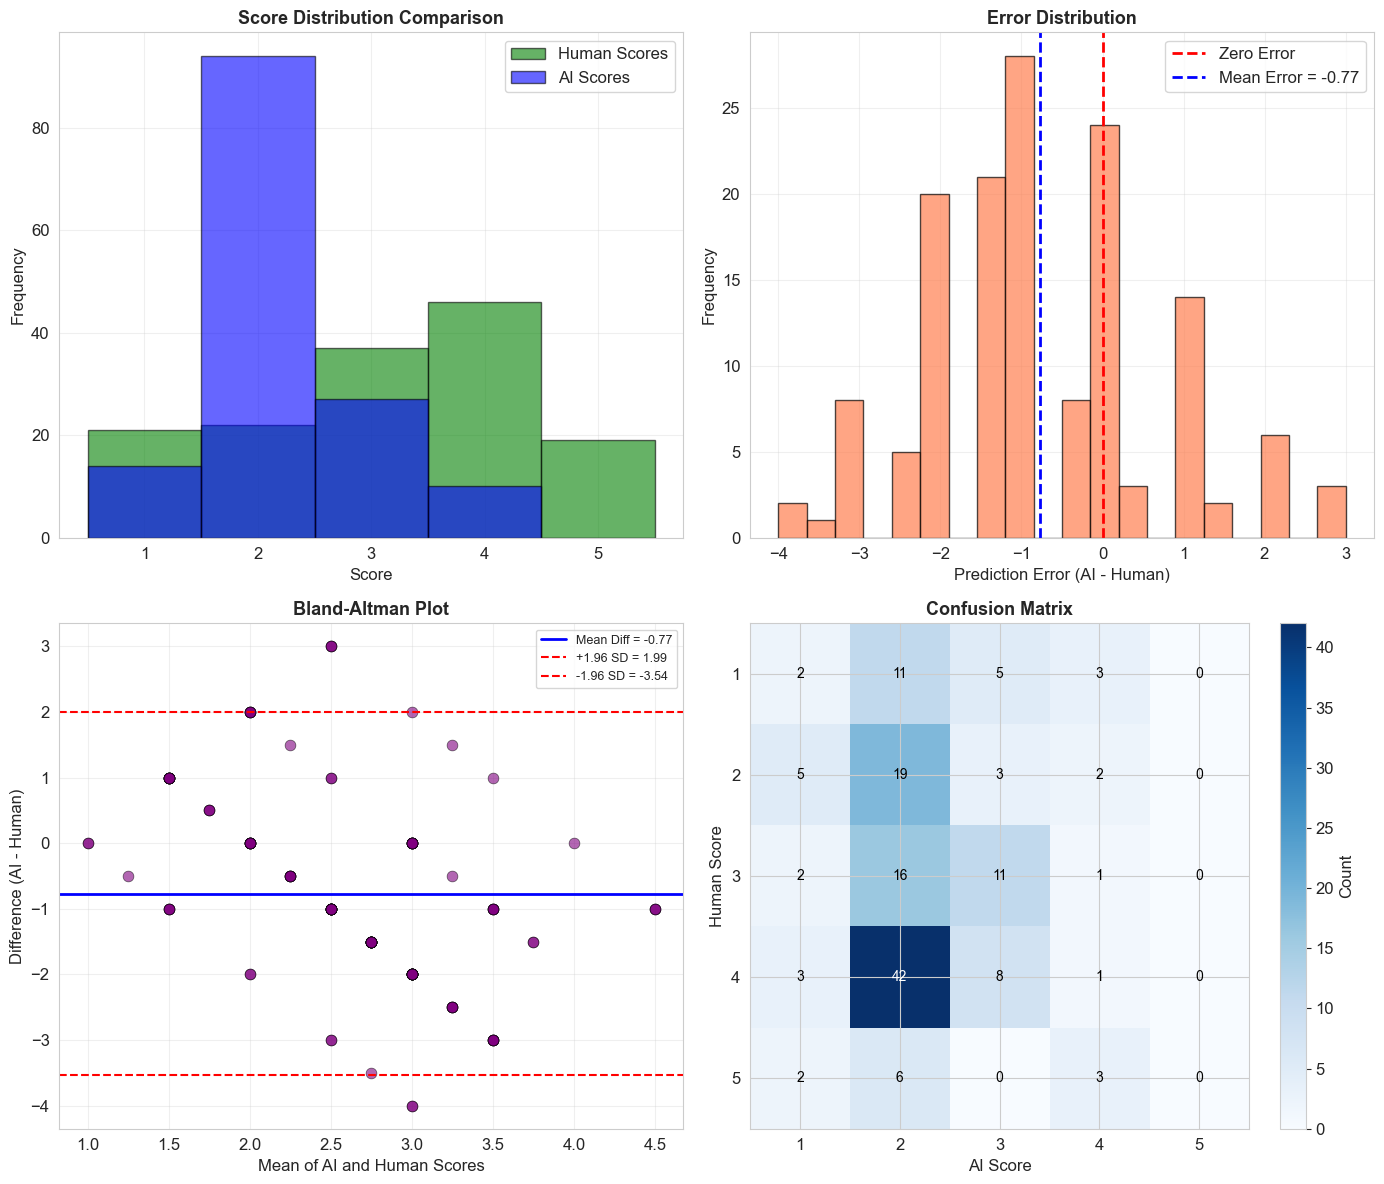

In [33]:
# Create a multi-panel figure with additional analyses
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Panel 1: Distribution comparison
ax1 = axes[0, 0]
bins = np.arange(0.5, 6, 1)
ax1.hist(human_scores, bins=bins, alpha=0.6, label='Human Scores', color='green', edgecolor='black')
ax1.hist(ai_scores, bins=bins, alpha=0.6, label='AI Scores', color='blue', edgecolor='black')
ax1.set_xlabel('Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Score Distribution Comparison', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Error distribution
ax2 = axes[0, 1]
errors = ai_scores - human_scores
ax2.hist(errors, bins=20, color='coral', edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.axvline(np.mean(errors), color='blue', linestyle='--', linewidth=2, label=f'Mean Error = {np.mean(errors):.2f}')
ax2.set_xlabel('Prediction Error (AI - Human)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Error Distribution', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Panel 3: Bland-Altman plot
ax3 = axes[1, 0]
mean_scores = (human_scores + ai_scores) / 2
diff_scores = ai_scores - human_scores
mean_diff = np.mean(diff_scores)
std_diff = np.std(diff_scores)

ax3.scatter(mean_scores, diff_scores, alpha=0.6, s=60, c='purple', edgecolors='black', linewidth=0.5)
ax3.axhline(mean_diff, color='blue', linestyle='-', linewidth=2, label=f'Mean Diff = {mean_diff:.2f}')
ax3.axhline(mean_diff + 1.96*std_diff, color='red', linestyle='--', linewidth=1.5, label=f'+1.96 SD = {mean_diff + 1.96*std_diff:.2f}')
ax3.axhline(mean_diff - 1.96*std_diff, color='red', linestyle='--', linewidth=1.5, label=f'-1.96 SD = {mean_diff - 1.96*std_diff:.2f}')
ax3.set_xlabel('Mean of AI and Human Scores', fontsize=12)
ax3.set_ylabel('Difference (AI - Human)', fontsize=12)
ax3.set_title('Bland-Altman Plot', fontsize=13, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Panel 4: Confusion matrix (binned)
ax4 = axes[1, 1]
from sklearn.metrics import confusion_matrix
# Round scores to nearest integer for confusion matrix
human_rounded = np.round(human_scores).astype(int)
ai_rounded = ai_scores.astype(int)
cm = confusion_matrix(human_rounded, ai_rounded, labels=[1, 2, 3, 4, 5])
im = ax4.imshow(cm, cmap='Blues', aspect='auto')
ax4.set_xticks([0, 1, 2, 3, 4])
ax4.set_yticks([0, 1, 2, 3, 4])
ax4.set_xticklabels([1, 2, 3, 4, 5])
ax4.set_yticklabels([1, 2, 3, 4, 5])
ax4.set_xlabel('AI Score', fontsize=12)
ax4.set_ylabel('Human Score', fontsize=12)
ax4.set_title('Confusion Matrix', fontsize=13, fontweight='bold')

# Add text annotations
for i in range(5):
    for j in range(5):
        text = ax4.text(j, i, cm[i, j], ha="center", va="center", color="black" if cm[i, j] < cm.max()/2 else "white", fontsize=10)

plt.colorbar(im, ax=ax4, label='Count')

plt.tight_layout()

# Save figure
output_file = RESULTS_DIR / 'detailed_analysis.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"✓ Detailed analysis figure saved to: {output_file}")

plt.show()


## 13. Export Results


In [34]:
# Export detailed results to CSV
results_file = RESULTS_DIR / 'evaluation_results_detailed.csv'
valid_df.to_csv(results_file, index=False)
print(f"✓ Detailed results saved to: {results_file}")

# Export metrics summary to JSON
metrics_file = RESULTS_DIR / 'evaluation_metrics.json'
with open(metrics_file, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"✓ Metrics summary saved to: {metrics_file}")

# Create a summary report
report_file = RESULTS_DIR / 'evaluation_report.txt'
with open(report_file, 'w') as f:
    f.write("="*70 + "\n")
    f.write("JOB MATCHING AGENT EVALUATION REPORT\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Model: {MODEL_NAME}\n")
    f.write(f"Temperature: {TEMPERATURE}\n")
    f.write(f"Evaluation Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("Dataset:\n")
    f.write(f"  - {NUM_CVS} CVs\n")
    f.write(f"  - {NUM_VACANCIES} Job Vacancies\n")
    f.write(f"  - {len(valid_df)} CV-Vacancy pairs evaluated\n\n")
    
    f.write("="*70 + "\n")
    f.write("KEY METRICS\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Pearson Correlation Coefficient: r = {pearson_r:.4f} (p = {pearson_p:.4e})\n")
    f.write(f"Spearman Rank Correlation: ρ = {spearman_r:.4f} (p = {spearman_p:.4e})\n")
    f.write(f"Mean Absolute Error (MAE): {mae:.4f}\n")
    f.write(f"Root Mean Squared Error (RMSE): {rmse:.4f}\n\n")
    
    f.write("="*70 + "\n")
    f.write("INTERPRETATION\n")
    f.write("="*70 + "\n\n")
    
    if abs(pearson_r) > 0.7:
        interpretation = "STRONG alignment with human judgment"
    elif abs(pearson_r) > 0.5:
        interpretation = "MODERATE alignment with human judgment"
    else:
        interpretation = "WEAK alignment with human judgment"
    
    f.write(f"The AI-based Job Matcher Agent demonstrates {interpretation}.\n\n")
    f.write(f"The Pearson correlation of {pearson_r:.3f} indicates a ")
    f.write(f"{'strong' if abs(pearson_r) > 0.7 else 'moderate' if abs(pearson_r) > 0.5 else 'weak'} ")
    f.write(f"linear relationship between AI and human scores.\n\n")
    f.write(f"The MAE of {mae:.3f} means that, on average, the AI's score differs from\n")
    f.write(f"the human score by {mae:.3f} points on a 1-5 scale.\n\n")
    
    f.write("="*70 + "\n")
    f.write("CONCLUSION\n")
    f.write("="*70 + "\n\n")
    
    if abs(pearson_r) > 0.7:
        f.write("The results support the claim that the LLM-based matching system achieves\n")
        f.write("human-level performance in assessing job-candidate compatibility.\n")
    elif abs(pearson_r) > 0.5:
        f.write("The results suggest that the LLM-based matching system shows promising\n")
        f.write("alignment with human judgment, though there is room for improvement.\n")
    else:
        f.write("The results indicate that the LLM-based matching system requires further\n")
        f.write("refinement to achieve stronger alignment with human judgment.\n")

print(f"✓ Evaluation report saved to: {report_file}")

print("\n" + "="*70)
print("EVALUATION COMPLETE")
print("="*70)
print(f"\nAll results saved to: {RESULTS_DIR}/")
print("\nFiles generated:")
print(f"  1. {results_file.name} - Detailed results with all scores")
print(f"  2. {metrics_file.name} - Metrics summary (JSON)")
print(f"  3. {report_file.name} - Human-readable report")
print(f"  4. ai_vs_human_scores_scatter.png - Main figure for paper")
print(f"  5. detailed_analysis.png - Additional visualizations")


✓ Detailed results saved to: evaluation_results\evaluation_results_detailed.csv
✓ Metrics summary saved to: evaluation_results\evaluation_metrics.json


UnicodeEncodeError: 'charmap' codec can't encode character '\u03c1' in position 27: character maps to <undefined>

## 14. Sample Results Inspection


In [ ]:
# Display some example predictions for qualitative analysis
print("="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

# Best matches (high human score, high AI score)
print("\n1. STRONG MATCHES (High Agreement):")
print("-" * 80)
strong_matches = valid_df[(valid_df['human_score_mean'] >= 4) & (valid_df['ai_score'] >= 4)].head(3)
for idx, row in strong_matches.iterrows():
    print(f"\nCV {row['cv_id']} → {row['job_title']}")
    print(f"  Human Score: {row['human_score_mean']:.1f} | AI Score: {row['ai_score']}")
    print(f"  AI Reason: {row['ai_reason'][:150]}...")

# Poor matches (low human score, low AI score)
print("\n\n2. POOR MATCHES (High Agreement):")
print("-" * 80)
poor_matches = valid_df[(valid_df['human_score_mean'] <= 2) & (valid_df['ai_score'] <= 2)].head(3)
for idx, row in poor_matches.iterrows():
    print(f"\nCV {row['cv_id']} → {row['job_title']}")
    print(f"  Human Score: {row['human_score_mean']:.1f} | AI Score: {row['ai_score']}")
    print(f"  AI Reason: {row['ai_reason'][:150]}...")

# Disagreements (large difference between human and AI)
print("\n\n3. DISAGREEMENTS (Large Discrepancy):")
print("-" * 80)
valid_df['score_diff'] = abs(valid_df['ai_score'] - valid_df['human_score_mean'])
disagreements = valid_df.nlargest(3, 'score_diff')
for idx, row in disagreements.iterrows():
    print(f"\nCV {row['cv_id']} → {row['job_title']}")
    print(f"  Human Score: {row['human_score_mean']:.1f} | AI Score: {row['ai_score']} | Diff: {row['score_diff']:.1f}")
    print(f"  AI Reason: {row['ai_reason'][:150]}...")

print("\n" + "="*80)
